In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

from tsprial.model_selection import TemporalSplit
from tsprial.forecasting import ForecastingCascade

In [3]:
### SIMULATE AR PROCESSES ###

timesteps = 2_000

np.random.seed(42)
df = np.random.randn(timesteps, 2)
for t in range(2, timesteps):
    df[t, 0] += 0.7*df[t-1, 0] + 0.1*df[t-2, 0]
    df[t, 1] += 0.8*df[t-1, 1] + 0.8*df[t-1, 0]

df = pd.DataFrame(df)
df.columns = ['y1','y2']

df.shape

(2000, 2)

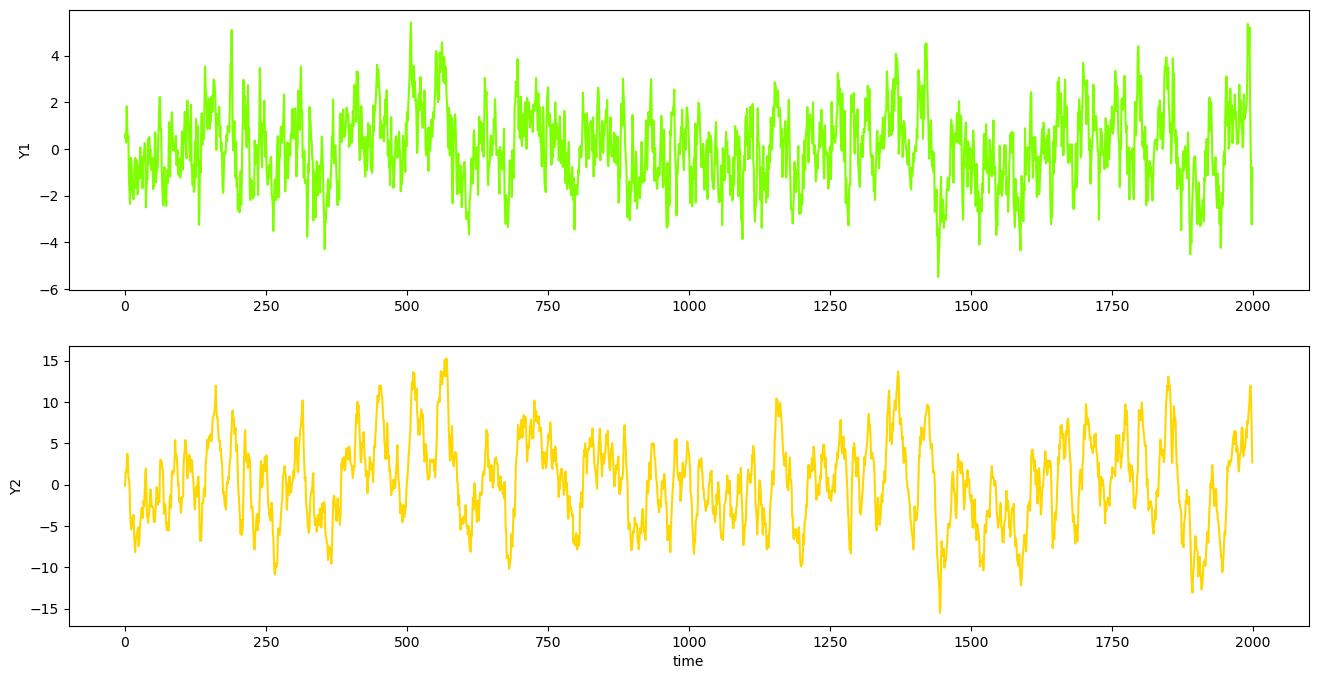

In [4]:
### PLOT SIMULATED AR PROCESSES ###

plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
df['y1'].plot(c='chartreuse')
plt.ylabel('Y1')
plt.subplot(2,1,2)
df['y2'].plot(c='gold')
plt.ylabel('Y2'); plt.xlabel('time')
plt.show()

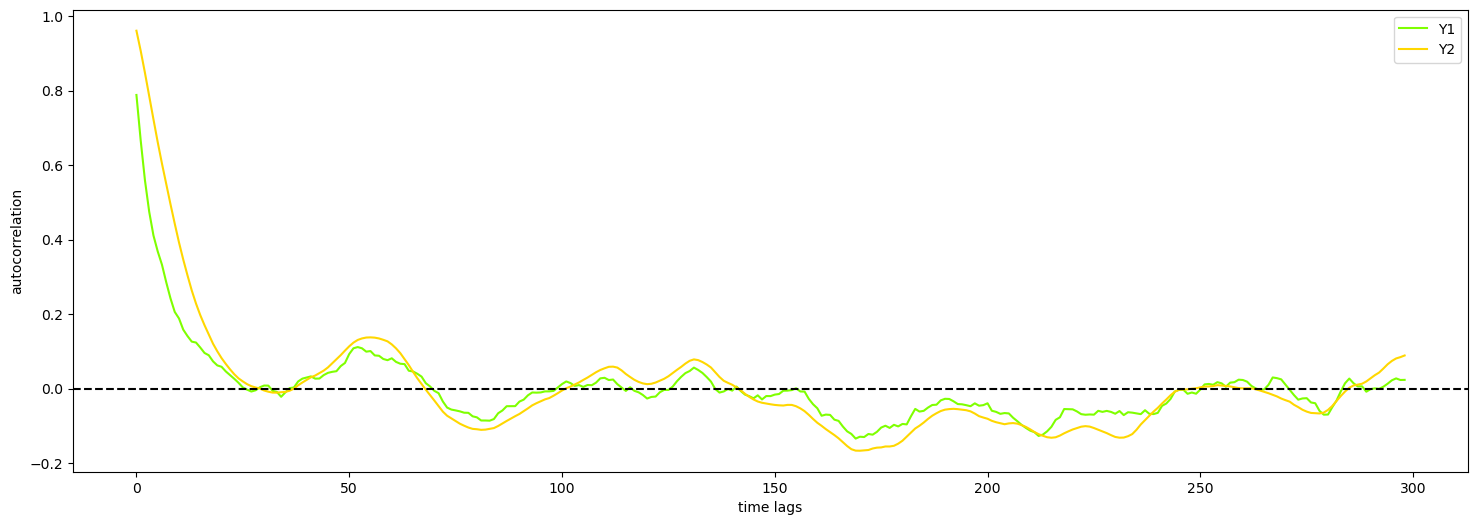

In [5]:
### AUTOCORRELATION OF AR PROCESSES ###

plt.figure(figsize=(18,6))
plt.plot([df['y1'].autocorr(l) for l in range(1,300)], 
         c='chartreuse', label='Y1')
plt.plot([df['y2'].autocorr(l) for l in range(1,300)], 
         c='gold', label='Y2')
plt.axhline(0, linestyle='--', c='black')
plt.ylabel('autocorrelation'); plt.xlabel('time lags')
plt.legend(); plt.show()

In [6]:
### AUTOCORRELATION OF AR PROCESSES OVER TIME ###

plt.figure(figsize=(18,6))
df['y1'].rolling(50).corr(df['y2']).plot(c='firebrick')
plt.axhline(0, linestyle='--', c='black')
plt.ylabel('correlation'); plt.xlabel('time')
plt.title(f"overall correlation: {round(stats.pearsonr(df['y1'],df['y2'])[0], 3)}")
plt.show()

In [7]:
### SET WORKING VARIABLES AND DEFINE TEST ON WHICH TO VERIFY GRANGER CAUSALITY ###

test_size = 300
lags = range(1,25)

df_train, df_test = train_test_split(
    df, test_size=test_size, shuffle=False
)

cv = TemporalSplit(n_splits=test_size, 
                   max_train_size=max(lags), test_size=1)

y_pred = {'y1 w/ y2':[], 'y2 w/ y1':[],
          'y1 w/o y2':[], 'y2 w/o y1':[]}

In [8]:
### TRAIN AND FORECAST MODEL WITHOUT EXOGENOUS VARIABLE ###

forecaster = ForecastingCascade(
    RandomForestRegressor(30, random_state=42, n_jobs=-1),
    lags=lags,
    use_exog=False,
)

model_y1 = clone(forecaster).fit(None, df_train['y1'])
model_y2 = clone(forecaster).fit(None, df_train['y2'])

for id_train,_ in tqdm(cv.split(df), total=cv.n_splits):
    y_pred['y1 w/o y2'].extend(
        model_y1.predict(
            [[0.]],
            last_y=df['y1'].iloc[id_train]
        )
    )
    y_pred['y2 w/o y1'].extend(
        model_y2.predict(
            [[0.]],
            last_y=df['y2'].iloc[id_train]
        )
    )

100%|██████████| 300/300 [01:02<00:00,  4.77it/s]


In [9]:
### TRAIN AND FORECAST MODEL WITH EXOGENOUS VARIABLE ###

forecaster = ForecastingCascade(
    make_pipeline(
        FunctionTransformer(
            lambda x: x[:,1:]  # remove current values of exog series
        ),
        RandomForestRegressor(30, random_state=42, n_jobs=-1)
    ),
    lags=lags,
    use_exog=True,
    exog_lags=lags,
)

model_y1y2 = clone(forecaster).fit(df_train[['y2']], df_train['y1'])
model_y2y1 = clone(forecaster).fit(df_train[['y1']], df_train['y2'])


for id_train,_ in tqdm(cv.split(df), total=cv.n_splits):
    y_pred['y1 w/ y2'].extend(
        model_y1y2.predict(
            pd.DataFrame({'y2': [0.]}),
            last_y=df['y1'].iloc[id_train],
            last_X=df[['y2']].iloc[id_train]
        )
    )
    y_pred['y2 w/ y1'].extend(
        model_y2y1.predict(
            pd.DataFrame({'y1': [0.]}),
            last_y=df['y2'].iloc[id_train],
            last_X=df[['y1']].iloc[id_train]
        )
    )

100%|██████████| 300/300 [01:05<00:00,  4.60it/s]


In [10]:
### MERGE TEST WITH PREDICTIONS ###

y_pred = pd.DataFrame(y_pred, index=df.index[-test_size:]).join(
    df, how='inner'
)

y_pred.head()

y1 w/ y2  y2 w/ y1  y1 w/o y2  y2 w/o y1        y1        y2
1700  3.641012  4.566784   3.315355   3.635806  3.253130  5.907566
1701  2.618040  7.309712   2.462085   7.172740  2.841928  7.229712
1702  2.292137  8.189390   2.039498   7.662030  2.750638  5.525066
1703  2.040402  6.263069   1.810017   5.154141  2.891709  6.746741
1704  2.190435  7.714393   2.196673   6.102029  2.076785  9.757622

In [11]:
### COMPARE RESIDUAL DISTRIBUTION FOR Y1 ###

stat, p_value = stats.kstest(
    (y_pred['y1'] - y_pred['y1 w/ y2'])**2, 
    (y_pred['y1'] - y_pred['y1 w/o y2'])**2
)

sns.histplot(
    data=(y_pred['y1'] - y_pred['y1 w/ y2'])**2,
    bins=1000, stat="density", element="step", 
    fill=False, cumulative=True, common_norm=False,
    color='firebrick', label='Y1 w/ Y2'
)
sns.histplot(
    data=(y_pred['y1'] - y_pred['y1 w/o y2'])**2,
    bins=1000, stat="density", element="step", 
    fill=False, cumulative=True, common_norm=False,
    color='grey', label='Y1 w/o Y2'
)
plt.title(f"KS test: (stat: {round(stat,3)}, p-value: {round(p_value,3)}) \n"
          f"MSE (Y1 w/ Y2): {round(((y_pred['y1'] - y_pred['y1 w/ y2']) **2).mean(),3)}, "
          f"MSE (Y1 w/o Y2): {round(((y_pred['y1'] - y_pred['y1 w/o y2']) **2).mean(),3)}")
plt.xlabel('cumulative residuals'); plt.legend()
plt.show()

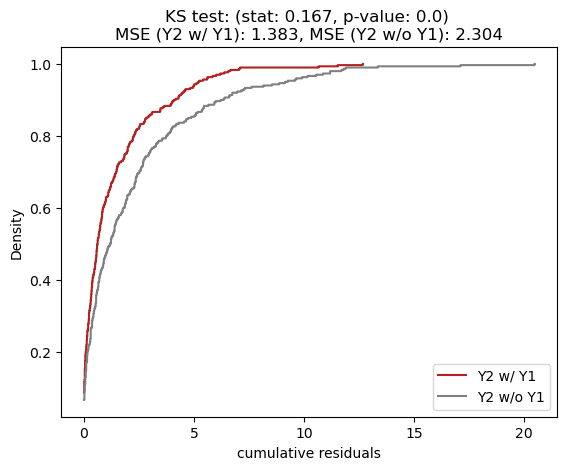

In [12]:
### COMPARE RESIDUAL DISTRIBUTION FOR Y2 ###

stat, p_value = stats.kstest(
    (y_pred['y2'] - y_pred['y2 w/ y1'])**2, 
    (y_pred['y2'] - y_pred['y2 w/o y1'])**2
)

sns.histplot(
    data=(y_pred['y2'] - y_pred['y2 w/ y1'])**2,
    bins=1000, stat="density", element="step", 
    fill=False, cumulative=True, common_norm=False,
    color='firebrick', label='Y2 w/ Y1'
)
sns.histplot(
    data=(y_pred['y2'] - y_pred['y2 w/o y1'])**2,
    bins=1000, stat="density", element="step", 
    fill=False, cumulative=True, common_norm=False,
    color='grey', label='Y2 w/o Y1'
)
plt.title(f"KS test: (stat: {round(stat,3)}, p-value: {round(p_value,3)}) \n"
          f"MSE (Y2 w/ Y1): {round(((y_pred['y2'] - y_pred['y2 w/ y1']) **2).mean(),3)}, "
          f"MSE (Y2 w/o Y1): {round(((y_pred['y2'] - y_pred['y2 w/o y1']) **2).mean(),3)}")
plt.xlabel('cumulative residuals'); plt.legend()
plt.show()